In [101]:
# one example about layer-feature extraction from: https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3

import torch
import torch.nn as nn
from torchvision import models

model = models.segmentation.fcn_resnet50(pretrained=True)
print(model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [107]:
# remove layer
new_classifier = nn.Sequential(*list(model.aux_classifier.children())[:0])

_model = model
_model.aux_classifier = new_classifier
print(_model)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

<PIL.Image.Image image mode=RGB size=400x271 at 0x1AD0007D208>


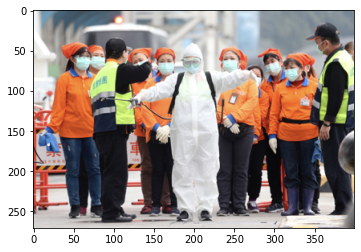

In [103]:
from PIL import Image
import matplotlib.pyplot as plt

im = Image.open('.Data/MaskImages/images/maksssksksss3.png' ).convert("RGB")
print(im)
#im.show() #opens gallery
plt.imshow(im)
#import cv2
#x =cv2.imread('.Data/MaskImages/images/maksssksksss3.png' )
#print(x.shape)
#plt.imshow(x)



In [104]:
from torchvision import transforms, datasets, models
import cv2
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

x = data_transform(im)
print(x.shape)
#print(x)



x = torch.transpose(x, 0,1)
x = torch.transpose(x, 1,2)
print(x.shape)

x= cv2.resize(x.numpy(), (64,64))
print(x.shape)

x= data_transform(x)
x = x[None,:,:,:]
print(x.shape)


torch.Size([3, 271, 400])
torch.Size([271, 400, 3])
(64, 64, 3)
torch.Size([1, 3, 64, 64])


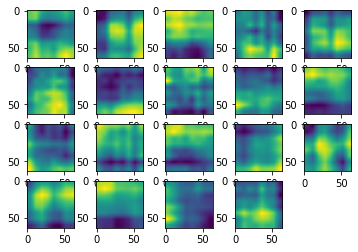

In [105]:
model.eval()
y = model(x)

fig = plt.figure()
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(y['out'][0,i].detach().numpy())

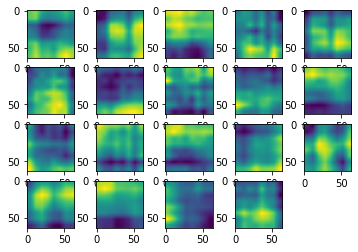

In [108]:
_model.eval()
yy = _model(x)

fig = plt.figure()
for i in range(1,20):
    plt.subplot(4,5,i)
    plt.imshow(yy['out'][0,i].detach().numpy())

<PIL.Image.Image image mode=RGB size=480x360 at 0x1AD60688AC8>


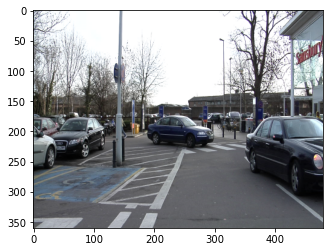

In [68]:
im = Image.open('.Data/CamVid/train/0006R0_f03450.png').convert("RGB")
print(im)
plt.imshow(im)

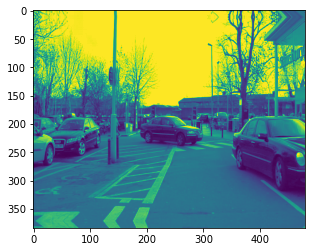

In [90]:

import albumentations as albu
import segmentation_models_pytorch as smp

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


image = cv2.imread('.Data/CamVid/train/0006R0_f03450.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

test_transform = albu.PadIfNeeded(384, 480)


"""_pad = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(384,480), 
    ])"""

x = test_transform(image=image)
x = preprocessing_fn(x['image'])
x = to_tensor(x)
plt.imshow(x[0])

In [51]:
fpn_model = torch.load('best_model.pth')
fpn_model.eval()

FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

In [91]:
x_tensor = torch.from_numpy(x).unsqueeze(0)
x_tensor.shape

torch.Size([1, 3, 384, 480])

torch.Size([1, 1, 384, 480])


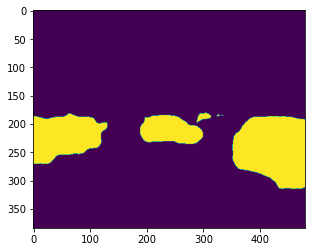

In [92]:
fpn_model.eval()
yy = fpn_model.predict(x_tensor)
print(yy.shape)

pr_mask = (yy.squeeze().numpy().round())

#plt.imshow(yy[0,0].detach().numpy())
plt.imshow(pr_mask)

8 November 20

In [1]:
import torch
import torch.nn as nn
from torchvision import models

original_model = models.alexnet(pretrained=True)

class AlexNetConv4(nn.Module):
            def __init__(self):
                super(AlexNetConv4, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_model.features.children())[:-3]
                )
            def forward(self, x):
                x = self.features(x)
                return x

model = AlexNetConv4()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\baran.tanriverdi/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


In [34]:
print(model)
print(original_model)

AlexNetConv4(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
)
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms, datasets, models
import cv2


import albumentations as albu
import segmentation_models_pytorch as smp

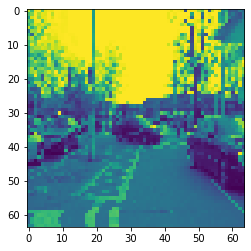

In [62]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


image = cv2.imread('.Data/CamVid/CamVid/train/0006R0_f03450.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

test_transform = albu.PadIfNeeded(384, 480)


"""_pad = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(384,480), 
    ])"""

x = test_transform(image=image)
#x = preprocessing_fn(x['image'])
x = cv2.resize(x['image'], (64,64))
x = to_tensor(x)
plt.imshow(x[0])

torch.Size([1, 3, 64, 64])
torch.Size([1, 256, 3, 3])


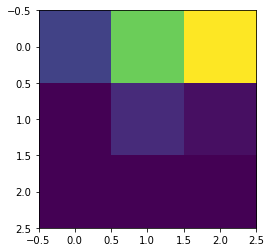

In [22]:
x_tensor = torch.from_numpy(x).unsqueeze(0)
print(x_tensor.shape)

y = model(x_tensor)
pr_mask = (y.detach().squeeze().numpy().round())
print(y.shape)
plt.imshow(pr_mask[1])

In [32]:
yy = original_model(x_tensor)
pr_mmask = (yy.detach().squeeze().numpy().round())
print(yy.shape)
#plt.imshow(pr_mmask[0])

torch.Size([1, 1000])


In [29]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
    

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])
print(output.shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
#print(torch.nn.functional.softmax(output[0], dim=0))
print(torch.nn.functional.softmax(output).shape)

Using cache found in C:\Users\baran.tanriverdi/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 1000])
torch.Size([1, 1000])


C:\Users\baran.tanriverdi\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


UNET

In [70]:
import torch
UNET = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\baran.tanriverdi/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [36]:
UNET

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [63]:
print(x.shape)
x = x.transpose(1, 2, 0).astype('float32')
X = cv2.resize(x, (32,32))
print(X.shape)

X = X.transpose(2, 0, 1).astype('float32')
print(X.shape)


(3, 64, 64)
(32, 32, 3)
(3, 32, 32)


torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])


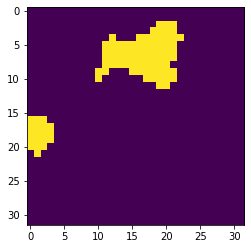

In [68]:
X_tensor = torch.from_numpy(X).unsqueeze(0)
print(X_tensor.shape)

Y = UNET(X_tensor)
pr_mask = (Y.detach().squeeze().numpy().round())
print(Y.shape)
plt.imshow(pr_mask)

In [71]:
best_UNET = torch.load('best_unet_model.pth')
print(best_UNET)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

torch.Size([1, 1, 384, 480])


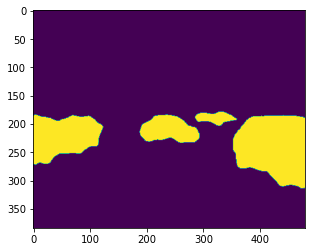

In [76]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


image = cv2.imread('.Data/CamVid/CamVid/train/0006R0_f03450.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

test_transform = albu.PadIfNeeded(384, 480)


"""_pad = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(384,480), 
    ])"""

x = test_transform(image=image)
x = preprocessing_fn(x['image'])
x = to_tensor(x)
plt.imshow(x[0])

x_tensor = torch.from_numpy(x).unsqueeze(0)
x_tensor.shape

best_UNET.eval()
yy = best_UNET.predict(x_tensor)
print(yy.shape)

pr_mask = (yy.squeeze().numpy().round())

#plt.imshow(yy[0,0].detach().numpy())
plt.imshow(pr_mask)